# Training and Evaluation
This notebook presents a minimal example of how to setup, train and evaluate the deep learning architecture presented in: 
*"A Flexible Deep Learning Architecture for Temporal Sleep Stage Classification using Accelerometry and Photoplethysmography".* 

The notebook is organized following the brilliant work from Chambon et al. 2018 $^{1}$.

Requirements: 
1. Install repository.
	- pip install -e
2. Install dependencies
	- dependencies
3. Prepare signal modalities and annotation in h5 files.
	- minimal_example/to_h5.py


Notes: 
This implementation varies slightly from the model presented in our original manuscrip (see above) in the following ways: 
- STFT is computed with less overlap between windows: Windows stride is 2 instead of 1. 
This halved the temporal input, and didn't reduce performance. 
- Likewise, STFT is computed with less overlap between frequency axis - to increase performance and decrease resolution. 
Consequenctly: Frequency axis had 32 points instead of 64 points.   
- Training is now using input augmentations.

###### $^{1}$ "S. Chambon, V. Thorey, P. J. Arnal, E. Mignot, A. Gramfort, "A deep learning architecture to detect events in EEG signals during sleep." IEEE 28th International Workshop on Machine Learning for Signal Processing (MLSP), 2018. [[Paper](https://arxiv.org/abs/1807.05981)|[Github](https://github.com/Dreem-Organization/dosed)]"

In [1]:
import os
import numpy as np

#print(os.getcwd()) # data path is relative to the current working directory, which is found using: print(os.getcwd()) 
os.chdir('C:\\Users\\mads_\\OneDrive - Danmarks Tekniske Universitet\\Dokumenter\\python\\MasterAlgorithm')
from datasets import get_train_validation_test

seed = 2022
#print(os.getcwd())

In [2]:
# data path is relative to the current working directory, which is found using: print(os.getcwd()) 

data_directory = '..\MasterAlgorithm\data\h5'
training_set, evaluation_set, test_set = get_train_validation_test(data_directory,
                                                    percent_test=40,
                                                    percent_validation=20,
                                                    seed=seed)

# Now we are ready 
print('training set: {}'.format(len(training_set)))
print('evaluation set: {}'.format(len(evaluation_set)))
print('test set: {}'.format(len(test_set)))

training set: 16
evaluation set: 4
test set: 12


# Dataset preparation

## Signal preprocessing. 
- "h5_path": string - path within h5 file to locate exact modality. 
- "channel_idx": list of integers - channel indexes to extract from the signal modality. 
- "preprocessing": list of dicts - defining preprocessing steps. A signal modality can have an arbitrary number of pre-processing steps.
- "batch_normalization": dict - assigning normalization actions to do during training. 
- "transformations": dict - assigning transformation (augmentation) operations to process the signal input with during training. 
- "add": boolean - assinging whether the different signal channels should be added after initial preprocessing (to reduce dimensionality).
- "fs_post": float - sample frequency of the preprocessed signal. 
- "dimensions": list of integers - dimensions of the preprocessed signal. 

Our algorithm assumes that both ACC and PPG have a sampling frequency of 32 Hz. If they do not, a resampling step should be added as the first preprocessing operation. 

In [4]:
signals_format =  {
    "ACC_merge_fft_spec": {
        "add": True,
        "fs_post": 0.5,
        "h5_path": "acc_signal",
        "dimensions": [
            32,
            1
        ],
        "channel_idx": [
            0,
            1,
            2
        ],
        "preprocessing": [
            {
                "args": {
                    "window_size": 30
                },
                "type": "median"
            },
            {
                "args": {
                    "iqr_window": 300,
                    "median_window": 300
                },
                "type": "iqr_normalization_adaptive"
            },
            {
                "args": {
                    "threshold": 20
                },
                "type": "clip_by_iqr"
            },
            {
                "args": {
                    "nfft": 512,
                    "f_max": 6,
                    "f_min": 0,
                    "f_sub": 3,
                    "window": 320,
                    "noverlap": 256
                },
                "type": "cal_psd"
            }
        ],
        "transformations": {
            "freq_mask": {},
            "time_mask": {},
            "image_translation": {}
        },
        "batch_normalization": {}
    },
    "PPG_fft_spec": {
        "add": False,
        "fs_post": 0.5,
        "h5_path": "ppg_signal",
        "dimensions": [
            32,
            1
        ],
        "channel_idx": [
            0
        ],
        "preprocessing": [
            {
                "args": {},
                "type": "zscore"
            },
            {
                "args": {},
                "type": "change_PPG_direction"
            },
            {
                "args": {
                    "iqr_window": 301,
                    "median_window": 301
                },
                "type": "iqr_normalization_adaptive"
            },
            {
                "args": {
                    "threshold": 20
                },
                "type": "clip_by_iqr"
            },
            {
                "args": {
                    "nfft": 512,
                    "f_max": 2.1,
                    "f_min": 0.1,
                    "f_sub": 1,
                    "window": 320,
                    "noverlap": 256
                },
                "type": "cal_psd"
            }
        ],
        "transformations": {
            "freq_mask": {},
            "time_mask": {},
            "image_translation": {}
        },
        "batch_normalization": {}
    }
}

## Event format
events are formatted with a name, their h5 relative path, and a probability. This probability is used during batch generation to balance the events. 


In [5]:
events = ['wake', 'light', 'deep', 'rem']
events_format = [
    {
        'name': 'wake', 
        'h5_path': 'wake',
        'probability': 1 / len(events)
    },
    {
        'name': 'light', 
        'h5_path': 'light',
        'probability': 1 / len(events)
    },
    {
        'name': 'deep', 
        'h5_path': 'deep',
        'probability': 1 / len(events)
    },
    {
        'name': 'rem', 
        'h5_path': 'rem',
        'probability': 1 / len(events)
    }
]

## Dataset class
The dataset class works as batch generator at training time. I handles preprocessing of the signal modalities, that are loaded from their specified h5 directories. 

- "records": list of strings - list of record filenames.
- "h5_directory": string - h5 directory of data files.
- "signal_format": list of dicts - directory and preprocessing steps for each signal modality (see above). 
- "window": interger - temporal window segment size (in seconds). 
- "number_of_channels": interger - number of signal modality inputs. 
- "events_format": list of dicts - format of events to model.  
- "prediction_resolution": integer - model output resolution (in seconds). 
- "overlap": float - consecutive window segments have this assigned overlap. Not used during balanced sampling. 
- "minimum_overlap": float - when signals are segmented, there is a risk of cutting off events. The minimum overlap is the required duration of an event that is cut off relative to the window size. 
- "batch_size": integer - batch size. 
- "mode": string - "inference" or "training".
- "cache_data": boolean - Cache preprocessing using Joblib.  
- "n_jobs": integer - starts parallel preprocessing. max is number of cores supported by local system.
- "seed": integer - seed.
- "use_mask": boolean - whether to apply mask. Mask must be defined as event in h5 file. 
- "load_signal_in_RAM": boolean - whether to load all preprocessed data in RAM during trianing (faster but requires memory).

In [6]:
from datasets import DatasetGenerator, BalancedDatasetGenerator

dataset_params = {
    "h5_directory": data_directory, 
    "signals_format": signals_format,
    "window": 30 * 2 ** 10, 
    "number_of_channels": len(signals_format), 
    "events_format": events_format,
    "prediction_resolution": 30,
    "overlap": 0.25,
    "minimum_overlap": 0.1,
    "batch_size": 2,
    "cache_data": True,
    "n_jobs": 4,
    "use_mask": True,
    "load_signal_in_RAM": True
}

ds_train = DatasetGenerator(records=training_set, mode="train", **dataset_params)
ds_evaluate = DatasetGenerator(records=evaluation_set, mode="inference", **dataset_params)
ds_test = DatasetGenerator(records=test_set, mode="inference", **dataset_params)

signal, event = ds_train.__getitem__(0)
print(signal.shape)
print(event.shape)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 53.71it/s]


(2, 15360, 32, 2)
(2, 1024, 4)


# Model creation

- "input shape": list of integers: [T, F, C] - Temporal dimension, Spatial dimension, Channel dimension - inferred from signals_format. 
- "num_classes": integer - number of classes - inferred from events_format
- "num_outputs": integer - number of model outputs (timesteps) - inferred from the signals_format
- "depth": integer integer - number of encoder and decoder layers in the network - M.
- "init_filter_num": integer - number of filters of the first encoder layer. 
- "filter_increment_factor": float - number of filters of layer n = number of filters of layer n-1 * filter_increment_factor. 
- "max_pool_size": tuple of integers - maxpool size used in each layer. 
- "kernel size": tuple of integers - kernel size of filters in each layer. 


In [7]:
from models import ResUNet

# model creation
model_params = {
    'input_shape': [int(ds_train.fsTime * ds_train.window), ds_train.nSpace, ds_train.nChannels], 
    'num_classes': len(events),
    'num_outputs': ds_train.window // ds_train.prediction_resolution,
    'depth': 9,
    'init_filter_num': 16,
    'filter_increment_factor': 2 ** (1 / 3),
    'max_pool_size': (2, 2),
    'kernel_size': (16, 3)
}

resunet = ResUNet(**model_params)
resunet.summary() # print summary.

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 15360, 32, 2 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 16384, 32, 2) 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 16384, 32, 16 1552        zero_padding2d[0][0]             
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 16384, 32, 16 64          conv2d[0][0]                     
______________________________________________________________________________________________

# training session

In [8]:
from tensorflow.keras.optimizers import Adam
from functions import loss_functions, metrics


resunet.compile(loss=loss_functions['weighted_loss'](**{'alpha': 0.35, 'gamma': 2}),
                run_eagerly=False,
                optimizer=Adam(learning_rate=1e-4, epsilon=1e-8),
                metrics=[metrics['cohens_kappa'](num_classes=len(events))])

history = resunet.fit(ds_train,
                      epochs=20,
                      verbose=1,
                      initial_epoch=0,
                      validation_data=ds_evaluate)


Epoch 1/20
16/16 [==============================] - 37s 815ms/step - loss: 0.3724 - cohens_kappa: 0.1024 - val_loss: 0.4143 - val_cohens_kappa: 0.0112

# Test Model 

In [10]:
from functions import metrics
kappa = metrics['cohens_kappa'](num_classes=len(events))
acc = metrics['binary_accuracy']()
acc_mu, kappa_mu = [], []

for idx in range(ds_test.__len__()): 
    
    sig, tar = ds_test.__getitem__(idx)
    pre = resunet.predict(sig)
    mask_include = tar.sum(axis=2) == 1 # remove time steps that do not have correct scoring:
    
    for b in range(pre.shape[0]):
        acc_mu += [acc(np.expand_dims(pre[b, mask_include[b, :]], axis=0), np.expand_dims(tar[b, mask_include[b, :]], axis=0))]
        kappa_mu += [kappa(np.expand_dims(pre[b, mask_include[b, :]], axis=0), np.expand_dims(tar[b, mask_include[b, :]], axis=0))]
    
print('accuracy: ', sum(acc_mu) / len(acc_mu))
print('Cohens kappa: ', sum(kappa_mu) / len(kappa_mu))

accuracy:  tf.Tensor(0.57741755, shape=(), dtype=float32)
Cohens kappa:  tf.Tensor(0.045507904, shape=(), dtype=float32)


# Test pretrained model: 


In [11]:
resunet_pretrained = ResUNet(**model_params)
resunet_pretrained.load_weights(filepath='models\\pretrained_weights\\model.059.h5')

In [12]:
from functions import metrics
# f1_by_class = metrics['f1_by_class'](beta=1, class_idx=0)
kappa = metrics['cohens_kappa'](num_classes=len(events))
acc = metrics['binary_accuracy']()
acc_mu, kappa_mu = [], []

for idx in range(ds_test.__len__()): 
    
    sig, tar = ds_test.__getitem__(idx)
    pre = resunet_pretrained.predict(sig)
    mask_include = tar.sum(axis=2) == 1 # remove time steps that do not have correct scoring:
    
    for b in range(pre.shape[0]):
        acc_mu += [acc(np.expand_dims(pre[b, mask_include[b, :]], axis=0), np.expand_dims(tar[b, mask_include[b, :]], axis=0))]
        kappa_mu += [kappa(np.expand_dims(pre[b, mask_include[b, :]], axis=0), np.expand_dims(tar[b, mask_include[b, :]], axis=0))]
    
print('accuracy: ', sum(acc_mu) / len(acc_mu))
print('Cohens kappa: ', sum(kappa_mu) / len(kappa_mu))

#[print(k) for k in kappa_mu]

accuracy:  tf.Tensor(0.78038645, shape=(), dtype=float32)
Cohens kappa:  tf.Tensor(0.34173858, shape=(), dtype=float32)


## Visualize

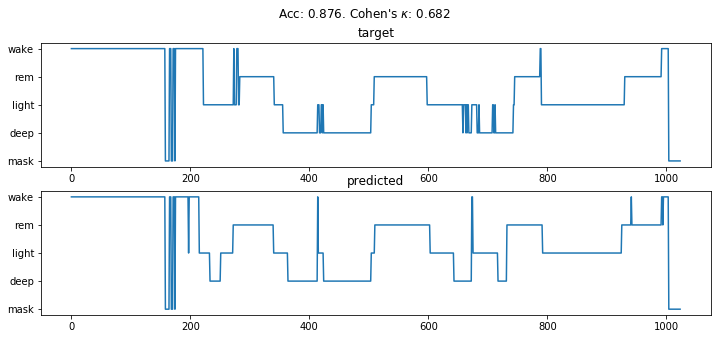

In [13]:
from matplotlib import pyplot as plt

idx = 11
batch_idx = 0

# predict
sig, tar_ = ds_test.__getitem__(idx)
pre_ = resunet_pretrained.predict(sig)

# select
tar = tar_[batch_idx, :, :]
pre = pre_[batch_idx, :, :]

# mask: 
mask = tar.sum(axis=1) != 1 # r
keep = tar.sum(axis=1) == 1 # r

# reformat to traditional hypnogram
tar_hyp = ds_test.hypnogram_plot_helper(tar, mask)
pre_hyp = ds_test.hypnogram_plot_helper(pre, mask)

# figures stuff
fig = plt.figure(figsize=(12., 5.))
gs = fig.add_gridspec(nrows=2, ncols=1)
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])

# plot 
ax1.plot(tar_hyp)
ax2.plot(pre_hyp)

# axis
fig.suptitle("Acc: {:.3f}. Cohen's $\kappa$: {:.3f}".format(
    acc(np.expand_dims(pre[keep], axis=0), np.expand_dims(tar[keep], axis=0)), 
    kappa(np.expand_dims(pre[keep], axis=0), np.expand_dims(tar[keep], axis=0))))

#ax1.yaxis.
ax1.set_title('target')
ax1.yaxis.set_ticklabels(['0', 'mask', 'deep', 'light', 'rem', 'wake'])
ax2.set_title('predicted')
ax2.yaxis.set_ticklabels(['0', 'mask', 'deep', 'light', 'rem', 'wake'])

plt.show()